In [1]:
import json
import pandas as pd
import numpy as np
import netwulf as nw
import matplotlib.pyplot as plt
import networkx as nx
import random as random 
pd.set_option('display.max_colwidth', None)

In [2]:
# read json file
with open('data/characters.json') as f:
    data = json.load(f)

In [3]:
# convert json to dataframe where each row is a character and each column is a key
df = pd.DataFrame(data['characters'])

df.head()

# remove rows with no character link
df = df[df['characterLink'].notnull()]

# print size of dataframe
print(df.shape)

# remove characterImageThumb, characterImageFull, marriedEngaged, kingsguard, guardedBy, servedBy, guardianOf
df = df.drop(['characterImageThumb', 'characterImageFull', 'marriedEngaged', 'kingsguard', 'guardedBy', 'servedBy', 'guardianOf'], axis=1)

# print rows where housename is not nan
df[df['houseName'].notnull()]

df.houseName.value_counts()


(368, 25)


Stark                     12
Baratheon                 10
Lannister                  9
Martell                    7
Frey                       6
Greyjoy                    5
Targaryen                  4
Tyrell                     4
Tully                      3
Mormont                    3
Bolton                     2
[Stark, Tully]             1
[Lannister, Baratheon]     1
[Stark, Targaryen]         1
[Arryn, Tully]             1
Umber                      1
Tarly                      1
[Bolton, Frey]             1
Name: houseName, dtype: int64

In [4]:
# create network of characters and link them to their houses
# create graph
G = nx.Graph()

# add nodes
G.add_nodes_from(df['characterName'])

# add one edge between each character if they are in the same house
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if df.iloc[i]['houseName'] == df.iloc[j]['houseName']:
            G.add_edge(df.iloc[i]['characterName'], df.iloc[j]['characterName'])


In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 349
Number of edges: 212


In [ ]:
# add node attributes to the graph from the df.columns names
for i in range(len(df)):
    for col in df.columns:
        G.nodes[df.iloc[i]['characterName']][col] = df.iloc[i][col]

In [ ]:
# remove nodes with no edge
G.remove_nodes_from(list(nx.isolates(G)))

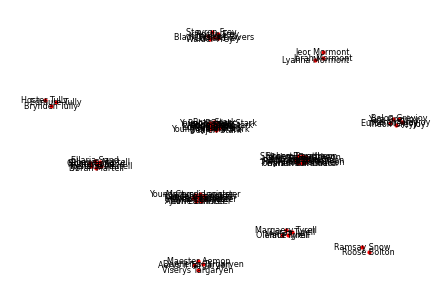

In [ ]:
# draw graph
nx.draw(G, with_labels=True, node_size=10, node_color='red', edge_color='black', font_size=8, width=0.1)

In [ ]:
# nw.visualize(G)

#### **Episodes**

In [5]:
# read episodes.json file
with open('data/episodes.json') as f:
    data_episodes = json.load(f)


In [6]:
# convert json to dataframe where each row is an scene and each column is a key
df_episodes = pd.DataFrame(data_episodes['episodes'])

# explode scenes column
df_episodes = df_episodes.explode('scenes')

# extract all scenes from the dataframe and create a new dataframe
df_scenes = pd.DataFrame(df_episodes['scenes'].tolist())

# make a list of episode numbers
episodeNum = []
seasonNum = []
for i in range(len(df_episodes)):
    episodeNum.append(df_episodes.iloc[i]['episodeNum'])
    seasonNum.append(df_episodes.iloc[i]['seasonNum'])

df_scenes['episodeNumber'] = episodeNum
df_scenes['seasonNumber'] = seasonNum

# remove greensight, altLocation, warg and flashback columns
df_scenes = df_scenes.drop(['greensight', 'altLocation', 'warg', 'flashback'], axis=1)
df_scenes.head()

# in the characters column, extract the name of each character and add it to a list where each row is a scene
characters = []
for i in range(len(df_scenes)):
    characters.append([])
    for j in range(len(df_scenes['characters'][i])):
        characters[i].append(df_scenes['characters'][i][j]['name'])

# add the list of characters to the dataframe
df_scenes['characters'] = characters


In [9]:
# create one list of all characters
all_characters = []
for i in range(len(df_scenes)):
    for j in range(len(df_scenes['characters'][i])):
        all_characters.append(df_scenes['characters'][i][j])

# create a list of unique characters
unique_characters = list(set(all_characters))
print(len(unique_characters))

577


In [49]:
# create graph of characters
G = nx.Graph()

# add nodes
G.add_nodes_from(unique_characters)

# add a weighted edge between each character if they appear in the same scene
for i in range(len(df_scenes)):
    for j in range(len(df_scenes['characters'][i])):
        for k in range(j+1, len(df_scenes['characters'][i])):
            G.add_edge(df_scenes['characters'][i][j], df_scenes['characters'][i][k], weight=1)

In [17]:
print(G.number_of_nodes())
print(G.number_of_edges())

577
4236


In [ ]:
# for each node, add the number of scenes they appear in as an attribute
for i in range(len(unique_characters)):
    G.nodes[unique_characters[i]]['numScenes'] = all_characters.count(unique_characters[i])

# print top 10 characters with most scenes
# sorted(G.nodes(data=True), key=lambda x: x[1]['numScenes'], reverse=True)[:10]

In [ ]:
# find top region and top sublocation for each character
top_region = []
top_sublocation = []
for i in range(len(unique_characters)):
    top_region.append([])
    top_sublocation.append([])
    for j in range(len(df_scenes)):
        if unique_characters[i] in df_scenes['characters'][j]:
            top_region[i].append(df_scenes['location'][j])
            top_sublocation[i].append(df_scenes['subLocation'][j])

# remove nan from top_region and top_sublocation
for i in range(len(top_region)):
    top_region[i] = [x for x in top_region[i] if str(x) != 'nan']
    top_sublocation[i] = [x for x in top_sublocation[i] if str(x) != 'nan']

# if top_region or top_sublocation is empty, add nan
for i in range(len(top_region)):
    if len(top_region[i]) == 0:
        top_region[i].append('nan')
    if len(top_sublocation[i]) == 0:
        top_sublocation[i].append('nan')

   
# add top location as an attribute to each node
for i in range(len(unique_characters)):
    G.nodes[unique_characters[i]]['topRegion'] = max(set(top_region[i]), key=top_region[i].count)
    G.nodes[unique_characters[i]]['topSublocation'] = max(set(top_sublocation[i]), key=top_sublocation[i].count)

# print top 10 characters with most scenes
sorted(G.nodes(data=True), key=lambda x: x[1]['numScenes'], reverse=True)[:10]

In [76]:
# add houseName as an attribute to each node
for i in range(len(unique_characters)):
    for j in range(len(df)):
        if unique_characters[i] == df.iloc[j]['characterName']:
            G.nodes[unique_characters[i]]['houseName'] = df.iloc[j]['houseName']

In [81]:
print("Jon Snow's attributes:", G.nodes["Jon Snow"])


Jon Snow's attributes: {'numScenes': 632, 'topRegion': 'The North', 'topSublocation': 'Castle Black', 'houseName': ['Stark', 'Targaryen']}


In [74]:
import community as community_louvain

# Find communities
partition = community_louvain.best_partition(G)

len(set(partition.values()))

13

In [84]:
# make hex colour schema for communities
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                for i in range(len(set(partition.values())))]

color_map = {}
for i, community in enumerate(set(partition.values())):
    color_map[community] = colors[i]

# assign community, color and degree to each node
for node in G.nodes:
    G.nodes[node]['community'] = partition[node]
    G.nodes[node]['color'] = color_map[partition[node]]
    G.nodes[node]['degree'] = G.degree[node]

In [99]:
# print nodes with community = 8
# for node in G.nodes:
    # if G.nodes[node]['community'] == 8:
        # print(node)

# find top location wihtin communities


# find top charachter based on numScenes within communities
top_characters = []
for i in range(len(set(partition.values()))):
    top_characters.append([])
    for node in G.nodes:
        if G.nodes[node]['community'] == i:
            top_characters[i].append(node)

# print top 10 characters in each community
top_character = []
for i in range(len(top_characters)):
    # print("Community", i)
    # print(sorted(top_characters[i], key=lambda x: G.nodes[x]['numScenes'], reverse=True)[:1])
    top_character.append(sorted(top_characters[i], key=lambda x: G.nodes[x]['numScenes'], reverse=True)[:1])

# add top character as an attribute to each node
for i in range(len(set(partition.values()))):
    for node in G.nodes:
        if G.nodes[node]['community'] == i:
            G.nodes[node]['topCommunitycharacter'] = top_character[i][0]


In [ ]:
# calculate modularity

In [36]:
# calculate average degree
avg_degree = 0
for node in G.nodes:
    avg_degree += G.degree[node]
avg_degree = avg_degree / G.number_of_nodes()
print(avg_degree)

14.682842287694974


In [38]:
# calculate the density of the graph
density = nx.density(G)
density

0.02549104563835933

TypeError: 'NoneType' object is not subscriptable

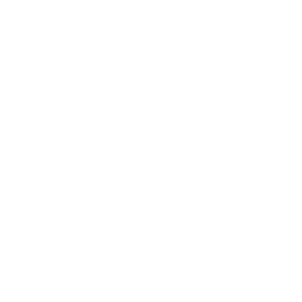

In [39]:
network, config = nw.visualize(G, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network)
plt.savefig("BAnetworkWithDegreeColoured.pdf")

In [ ]:
# print node attributes for nodes with highest degree
for node in sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[:20]:
    print(node, G.nodes[node])

Arya Stark {'characterName': 'Arya Stark', 'characterLink': '/character/ch0158604/', 'actorName': 'Maisie Williams', 'actorLink': '/name/nm3586035/', 'houseName': 'Stark', 'royal': nan, 'parents': ['Eddard Stark', 'Catelyn Stark'], 'siblings': ['Robb Stark', 'Sansa Stark', 'Bran Stark', 'Rickon Stark'], 'killedBy': nan, 'nickname': nan, 'killed': ['Red Keep Stableboy', 'Frey Soldier #1', 'Polliver', 'Rorge', 'Ghita', 'Meryn Trant', 'The Waif', 'Black Walder Rivers', 'Lothar Frey', 'Walder Frey', 'Petyr Baelish', 'The Night King', 'White Walker', 'Viserion'], 'parentOf': nan, 'serves': nan, 'actors': nan, 'allies': nan, 'abductedBy': nan, 'abducted': nan, 'sibling': nan, 'community': 5, 'color': '#28518F', 'degree': 156}
Tyrion Lannister {'characterName': 'Tyrion Lannister', 'characterLink': '/character/ch0146096/', 'actorName': 'Peter Dinklage', 'actorLink': '/name/nm0227759/', 'houseName': 'Lannister', 'royal': nan, 'parents': ['Tywin Lannister'], 'siblings': ['Cersei Lannister', 'Jai

Community 0
Addam Marbrand
Areo Hotah
Armeca
Brienne of Tarth
Bronn
Captain of the Archers
Cersei Lannister
Colen of Greenpools
Daisy
Dickon Tarly
Dontos Hollard
Doran Martell
Ellaria Sand
Euron Greyjoy
Grand Maester Pycelle
Gregor Clegane
Hallyne
Handmaid
High Septon
High Sparrow
Ilyn Payne
Jaime Lannister
Joffrey Baratheon
Jon Arryn
Kayla
Kevan Lannister
King Joffrey Baratheon Dwarf
King Renly Baratheon Dwarf
King Robb Stark Dwarf
King Stannis Baratheon Dwarf
Kinvara
Lancel Lannister
Lannister Captain
Lannister Messenger
Lead Dornish Guard
Leo Lefford
Lollys Stokeworth
Loras Tyrell
Lord Varys
Mace Tyrell
Maester Wolkan
Mandon Moore
Marei
Margaery Tyrell
Margaery's Handmaiden
Marillion
Merchant Captain
Meryn Trant
Mirelle
Myrcella Baratheon
Nymeria Sand
Obara Sand
Oberyn Martell
Olenna Tyrell
Olyvar
Petyr Baelish
Podrick Payne
Qyburn
Randyll Tarly
Red Priestess
Renly Baratheon
Ros
Sansa Stark
Septa Moelle
Septa Scolera
Septa Unella
Shae
Shagga
Steelshanks Walton
The Bear
Timett
Tommen